In [122]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor
import xgboost
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error



import matplotlib.pyplot as plt
%matplotlib inline

In [194]:
boston_data = load_boston()
X = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
y = pd.Series(boston_data['target'], name='Price')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

In [195]:
n_estimators = 100
gbt = GradientBoostingRegressor(
    # Loss function for training
    loss='ls',
    # Boosting hyper-parameters
    learning_rate=0.05,
    n_estimators=1000,
    # Tree growing hyper-parameters
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    max_leaf_nodes=None,
    max_features=None,
    subsample=1.0,
    # Early stopping
    validation_fraction=0.2,
    n_iter_no_change=50,
    tol=0.0001,
    # Extra
    random_state=43,
    verbose=1,
)


In [196]:
gbt.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1          72.5873            0.99s
         2          66.5909            0.99s
         3          61.4474            1.32s
         4          56.4727            1.24s
         5          51.9279            1.19s
         6          47.8497            1.16s
         7          44.1120            1.13s
         8          40.7528            1.11s
         9          37.6838            1.10s
        10          34.9064            1.09s
        20          17.6463            0.98s
        30          10.5320            1.03s
        40           7.2191            0.93s
        50           5.3444            0.83s
        60           4.3587            0.81s
        70           3.6931            0.77s
        80           3.1934            0.78s
        90           2.8365            0.73s
       100           2.5802            0.69s


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=50, presort='auto', random_state=43,
                          subsample=1.0, tol=0.0001, validation_fraction=0.2,
                          verbose=1, warm_start=False)

MSE Validation: 10.8153


Text(0, 0.5, 'Deviance')

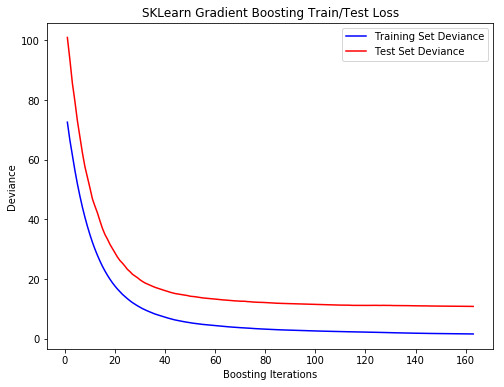

In [205]:
# Plot training deviance
mse = mean_squared_error(y_test, gbt.predict(X_test))
print(f"MSE Validation: {mse:.4f}")

n_estimators = len(gbt.estimators_)

# compute test set deviance
test_score = np.zeros((n_estimators,), dtype=np.float64)

for i, y_pred in enumerate(gbt.staged_predict(X_test)):
    test_score[i] = gbt.loss_(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8, 6))
plt.title('SKLearn Gradient Boosting Train/Test Loss')
ax.plot(np.arange(n_estimators) + 1, gbt.train_score_, 'b-',
         label='Training Set Deviance')
ax.plot(np.arange(n_estimators) + 1, test_score, 'r-',
         label='Test Set Deviance')
ax.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

In [198]:
# XGBoost
xgb = xgboost.XGBRegressor(
    # Loss function and weak learner type
    objective='reg:squarederror',
    booster='gbtree',
    eval_metric=['rmse', 'mae'],
    base_score=0.5,
    # Boosting hyper-parameters
    learning_rate=0.1,  # Also called: eta
    n_estimators=1000,
    reg_alpha=0,  # L1 regularization
    reg_lambda=10,  # L2 regularization
    max_delta_step=0,
    # Tree growing hyper-parameters
    max_depth=3,
    gamma=0,  # Also called: min_split_loss
    min_child_weight=1,
    subsample=0.8,
    scale_pos_weight=1,
    # These 3 parameters determine the n. of features to use for splits
    colsample_bytree=0.8,
    colsample_bylevel=1,
    colsample_bynode=1,
    # Extra
    importance_type='gain',  # For feature importance
    verbosity=1,
    n_jobs=1,
    nthread=None,
    seed=42,
)

In [199]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xgb.fit(X_train, y_train, eval_set=eval_set, early_stopping_rounds=20, verbose=False)

C:\Users\crist\Envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8,
             eval_metric=['rmse', 'mae'], gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=42,
             silent=None, subsample=0.8, verbosity=1)

MSE Validation: 8.6176


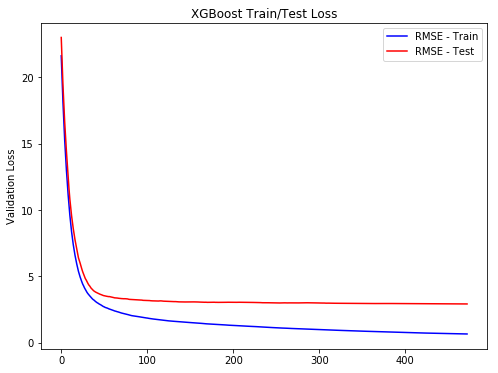

In [207]:
mse = mean_squared_error(y_test, xgb.predict(X_test))
print(f"MSE Validation: {mse:.4f}")

results = xgb.evals_result_
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot RMSE
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_axis, results['validation_0']['rmse'], color='blue', label='RMSE - Train')
ax.plot(x_axis, results['validation_1']['rmse'], color='red', label='RMSE - Test')
ax.legend()
plt.ylabel('Validation Loss')
plt.title('XGBoost Train/Test Loss')
plt.show()